In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-1.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-2.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-3.csv


In [2]:
import warnings
warnings.simplefilter(action = "ignore" ,category = FutureWarning)

In [3]:
# Import libraries here
from glob import glob

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Build your `wrangle` function
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    mask_pt = df["property_type"].str.contains("apartment")
    mask_mc = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_p = df["price_aprox_usd"]  < 100_000
    df= df[mask_pt & mask_mc & mask_p] 
    
    #removing outliers
    low, high = df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_out = df["surface_covered_in_m2"].between(low,high)
    df = df[mask_out]
    #removing lat-lon
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df.drop(columns = "lat-lon", inplace = True)
    
    # selecting boroughs
    df["borough"] = df["place_with_parent_names"].str.split("|", expand = True)[1]
    df.drop(columns = ["place_with_parent_names"], inplace = True)
    
     #dropping more than 50 percent null values
    df.drop(columns = ["surface_total_in_m2", "price_usd_per_m2","floor","rooms","expenses"], inplace = True)
    
    #low- or high-cardinality
    df.drop( columns = ["operation", "property_type", "currency","properati_url"] , inplace =True)
    #leakage
    df.drop( columns = ["price_aprox_local_currency", "price_per_m2", "price"] , inplace =True)
    
    
    return df


In [5]:
files = glob("/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-*.csv")
files

['/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-1.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-2.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-3.csv']

In [6]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5473 non-null   int64  
 1   price_aprox_usd        5473 non-null   float64
 2   surface_covered_in_m2  5473 non-null   float64
 3   lat                    5149 non-null   float64
 4   lon                    5149 non-null   float64
 5   borough                5473 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 256.7+ KB
None


,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,2,82737.39,75.0,19.362690,-99.150565,Benito Juárez
1,4,72197.60,62.0,19.291345,-99.124312,Tlalpan
2,5,44277.72,85.0,19.354987,-99.061709,Iztapalapa
3,14,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
4,19,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


In [7]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat= "lat",
    lon= "lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color= "price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [8]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x= "lat",
    y="lon",
    z= "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

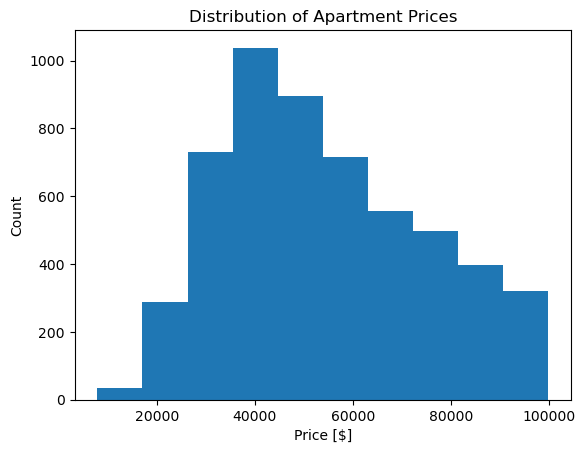

In [9]:
# Build histogram
plt.hist(df["price_aprox_usd"])
plt.xlabel("Price [$]")
plt.ylabel("Count")
plt.title("Distribution of Apartment Prices")
plt.show()

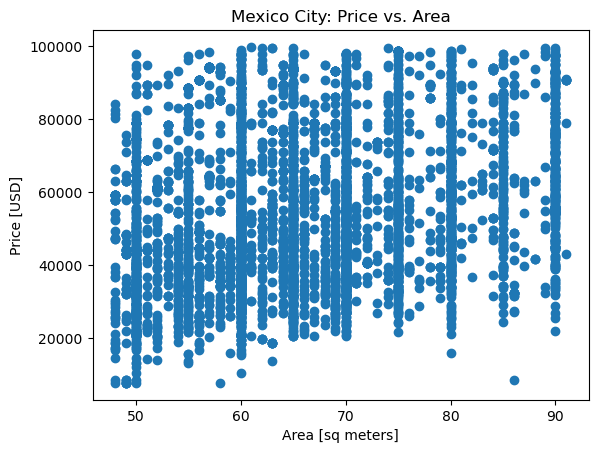

In [10]:
# Build scatter plot
plt.scatter(df["surface_covered_in_m2"],df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");


In [11]:
# Split data into feature matrix `X_train` and target vector `y_train`.
features = ["surface_covered_in_m2","lat","lon","borough"]
target = "price_aprox_usd"
X_train = df[features]
y_train = df[target]

In [12]:
#Building Baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


In [13]:
# instantiate
ohe = OneHotEncoder(use_cat_names = True)
#fit
ohe.fit(X_train)

XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(5473, 18)


,surface_covered_in_m2,lat,lon,borough_Benito Juárez,borough_Tlalpan,borough_Iztapalapa,borough_Gustavo A. Madero,borough_Venustiano Carranza,borough_Iztacalco,borough_Coyoacán,borough_Cuauhtémoc,borough_Miguel Hidalgo,borough_Azcapotzalco,borough_Tláhuac,borough_Álvaro Obregón,borough_La Magdalena Contreras,borough_Xochimilco,borough_Cuajimalpa de Morelos
0,75.0,19.362690,-99.150565,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,62.0,19.291345,-99.124312,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,85.0,19.354987,-99.061709,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,52.0,19.469681,-99.086136,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,53.0,19.443592,-99.121407,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
# Build Model
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [15]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error (y_train, y_pred_training))

Training MAE: 14943.165824063904


In [16]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 18
['surface_covered_in_m2' 'lat' 'lon' 'borough_1' 'borough_2']


In [19]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon":lon,
        "borough": borough
        
    }
    df = pd.DataFrame(data, index= [0])
    y_test_pred = model.predict((df.round(2)))[0]
    return f"Predicted apartment price: ${mean_absolute_error(y_train, y_test_pred)}"

In [20]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature namesfeature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 18
['surface_covered_in_m2' 'lat' 'lon' 'borough_1' 'borough_2']
features len: 18
['surface_covered_in_m2' 'lat' 'lon' 'borough_1' 'borough_2']


In [21]:
coefficients = model.named_steps["ridge"].intercept_
features = model.named_steps["ridge"].coef_
feat_imp = pd.Series(coefficients , index = feature_names)
feat_imp

surface_covered_in_m2   -222998.231308
lat                     -222998.231308
lon                     -222998.231308
borough_1               -222998.231308
borough_2               -222998.231308
borough_3               -222998.231308
borough_4               -222998.231308
borough_5               -222998.231308
borough_6               -222998.231308
borough_7               -222998.231308
borough_8               -222998.231308
borough_9               -222998.231308
borough_10              -222998.231308
borough_11              -222998.231308
borough_12              -222998.231308
borough_13              -222998.231308
borough_14              -222998.231308
borough_15              -222998.231308
dtype: float64